In [2]:
import matplotlib.pyplot as plt
import scipy.optimize as opt
import numpy as np


# Что делаем?

<b> Постановка задачи:</b> есть трехслойниый симметричный волновод толщиной $d$, показатели преломления обкладок - $n_0$, сердцевины - $n_1$. В него попадает ЭМ волна с волновым числом $k$ и возбуждает 0ю моду. Ориентация кристалла -  ось 100 кристалла ориентирована под углом $\phi$ к проекции волнового вектора на плоскость ХУ, ось 001.

<b> Цель:</b>  получить зависимость поля ОЭКМ от параметров.

Большая часть поворотов, умножений, взятия производных матриц и тензоров была проделана в ВФ Математике, здесь будет решение модового уравнения и последующее построение графиков распределения полей в зависимости от значения параметров

вывод формул ОЭКМ в <code>waveguide ICME.nb</code> 




![shit](1x/2.png)

In [22]:
width = 0.6
n1 = 1.5
n2 = np.sqrt(5.5)
n3 = n1

# mode eqs

def TE_mode_eq(k, beta, N=0):
    p = np.sqrt(beta**2 - (k*n1)**2)
    q = np.sqrt(-beta**2 + (k*n2)**2)
    r = np.sqrt(beta**2 - (k*n3)**2)
    tmp = np.arctan(q*(p+r)/(q*q - p*r))
    if (q*q - p*r) < 0:
        tmp += np.pi
        
    return np.real(width*q - np.pi*(N) - tmp)

def TM_mode_eq(k, beta, N=0):
    p = np.sqrt(beta**2 - (k*n1)**2)
    q = np.sqrt(-beta**2 + (k*n2)**2)
    r = np.sqrt(beta**2 - (k*n3)**2)
    return np.real(width*q - np.arctan(n2**2*p/n1**2/q) - np.arctan(n2**2*r/n3**2/q) - np.pi*N)

# get solution for selected lambda

def sol_mode_eq(lam, mode='TE'):
    mode_eq = TE_mode_eq if mode=='TE' else TM_mode_eq
    k = 2*np.pi/lam
    l_b = k*(n1 + 1e-3)
    r_b = k*(n2 - 1e-3)
    # print(k, l_b, r_b)
    
    if mode_eq(k, l_b)*mode_eq(k, r_b) < 0:
        return opt.brentq(lambda x: mode_eq(k, x), l_b, r_b)
    else:
        return None

def get_E_field_TE(beta, lam, z): #TODO make correct normalization
    k = 2*np.pi/lam
    r = np.sqrt(beta**2 - (k*n3)**2)
    q = np.sqrt(-beta**2 + (k*n2)**2)
    
    return np.cos(q*z) + r/q*np.sin(q*z)

def get_E_field_TM(beta, lam, z):
    k = 2*np.pi/lam
    p = np.sqrt(beta**2 - (k*n1)**2)
    q = np.sqrt(-beta**2 + (k*n2)**2)

    Ez = beta*(-n1**2*q/(n2**2*p)*np.cos(q*z) - np.sin(q*z))
    Ex = -1j*q*(-n1**2*q/(n2**2*p)*np.sin(q*z) + np.cos(q*z))
    return Ex, Ez

# calculate ICME according to phi 
g1 = 107145
g2 = 59525
g3 = 14880

g1 /= g3
g2 /= g3
g3 /= g3

def ICME_TE(Ey, phi, M):
    m1, m2, m3 = M
    cos = np.cos(phi)
    sin = np.sin(phi)
    Hx = 2*(g2*cos**3*m1 - (g1-2*g3)*(cos**2*m2*sin 
        - cos*m1*sin**2) - g2*m2*sin**3)
    Hy = 2*(g1*cos**3*m2 + (g2+2*g3)*cos**2*sin*m1
        + (g2+2*g3)*cos*sin**2*m2 + g1*sin**3*m1)
    Hz = 2*g2*m3

    Hx *= Ey**2
    Hy *= Ey**2
    Hz *= Ey**2

    return(Hx, Hy, Hz)

def ICME_TM(E, phi, M):
    Ex, Ez = E
    Ex *= Ex
    Ez *= Ez 

    m1, m2, m3 = M
    cos = np.cos(phi)
    sin = np.sin(phi)

    Hx = 2*np.real(-Ex*g1*cos**3*m1 + Ex*(g2 + 2*g3)*cos**2*sin*m2 
        + m2*sin*(-Ez*g2 + Ex*g1*sin**2) 
        + cos*m1*(Ez*g2 - Ex*(g2 + 2*g3)*sin**2))
    Hy = -2*np.real(Ex*g2*cos**3*m2 + Ex*(g1 - 2*g3)*cos**2*sin*m1 
        + g2*m1*sin*(-Ez + Ex*sin**2) + cos*m2*(-Ez*g2 
        + Ex*(g1 - 2*g3)*sin**2))
    Hz = 2*np.real(Ez*g1 - Ex*g2)*m3

    return (Hx, Hy, Hz)

def ICME_arbirtary_E(E, phi, M):
    Ex, Ey, Ez = E
    Excon = np.conjugate(Ex)
    Eycon = np.conjugate(Ey)
    Ezcon = np.conjugate(Ez)
    m1, m2, m3 = M
    cos = np.cos(phi)
    sin = np.sin(phi)

    Hx = 2*np.real(cos**3*(Ex*Excon*g1*m1 + Ey*Eycon*g2*m1 + 
        Excon*Ey*g3*m2 + Ex*Eycon*g3*m2) - cos**2*(-((Excon*Ez +
        Ex*Ezcon)*g3*m3) + (Excon*Ey*(-g1 + g2 + g3)*m1 + 
        Ex*Eycon*(-g1 + g2 + g3)*m1 + Ey*Eycon*(g1 - 2*g3)*m2 + 
        Ex*Excon*(g2 + 2*g3)*m2)*sin) + sin*(-Ez*Ezcon*g2*m2 + 
        (Excon*Ez + Ex*Ezcon)*g3*m3*sin + (Excon*Ey*g3*m1 
        + Ex*Eycon*g3*m1 - Ex*Excon*g1*m2 - Ey*Eycon*g2*m2)*sin**2) + 
        cos*(Ez*Ezcon*g2*m1 + (Ey*Eycon*(g1 - 2*g3)*m1 
        + Ex*Excon*(g2 + 2*g3)*m1 + Excon*Ey*(g1 - g2 - g3)*m2 + 
        Ex*Eycon*(g1 - g2 - g3)*m2)*sin**2))   

    Hy = 2*np.real(cos**3*(Excon*Ey*g3*m1 + Ex*Eycon*g3*m1 + 
        Ey*Eycon*g1*m2 + Ex*Excon*g2*m2) + cos**2*((Eycon*Ez +
        Ey*Ezcon)*g3*m3 + (Ex*Excon*(g1 - 2*g3)*m1 + Ey*Eycon*(g2 
        + 2*g3)*m1 + Excon*Ey*(-g1 + g2 + g3)*m2 + Ex*Eycon*(-g1 
        + g2 + g3)*m2)*sin) + sin*(Ez*Ezcon*g2*m1 + (Eycon*Ez + 
        Ey*Ezcon)*g3*m3*sin + (Ey*Eycon*g1*m1 + Ex*Excon*g2*m1 - 
        Excon*Ey*g3*m2 - Ex*Eycon*g3*m2)*sin**2) + cos*(Ez*Ezcon*g2*m2 + 
        (Excon*Ey*(g1 - g2 - g3)*m1 + Ex*Eycon*(g1 - g2 - g3)*m1 + 
        Ex*Excon*(g1 - 2*g3)*m2 + Ey*Eycon*(g2 + 2*g3)*m2)*sin**2))

    Hz = 2*np.real(g3*cos*(Excon*Ez*m1 + Ex*Ezcon*m1 + 
        (Eycon*Ez + Ey*Ezcon)*m2) + (Ez*Ezcon*g1 + Ex*Excon*g2 + 
        Ey*Eycon*g2)*m3 + g3*(Eycon*Ez*m1 + Ey*Ezcon*m1 - 
        (Excon*Ez + Ex*Ezcon)*m2)*sin)

    return (Hx, Hy, Hz)

def get_M_from_H(H, psi, phi, out_of_plane):
    rel_ang = psi - phi

    m1 = H*np.cos(rel_ang)*np.cos(out_of_plane)
    m2 = H*np.sin(rel_ang)*np.cos(out_of_plane)
    m3 = H*np.sin(out_of_plane)

    return (m1, m2, m3)
    


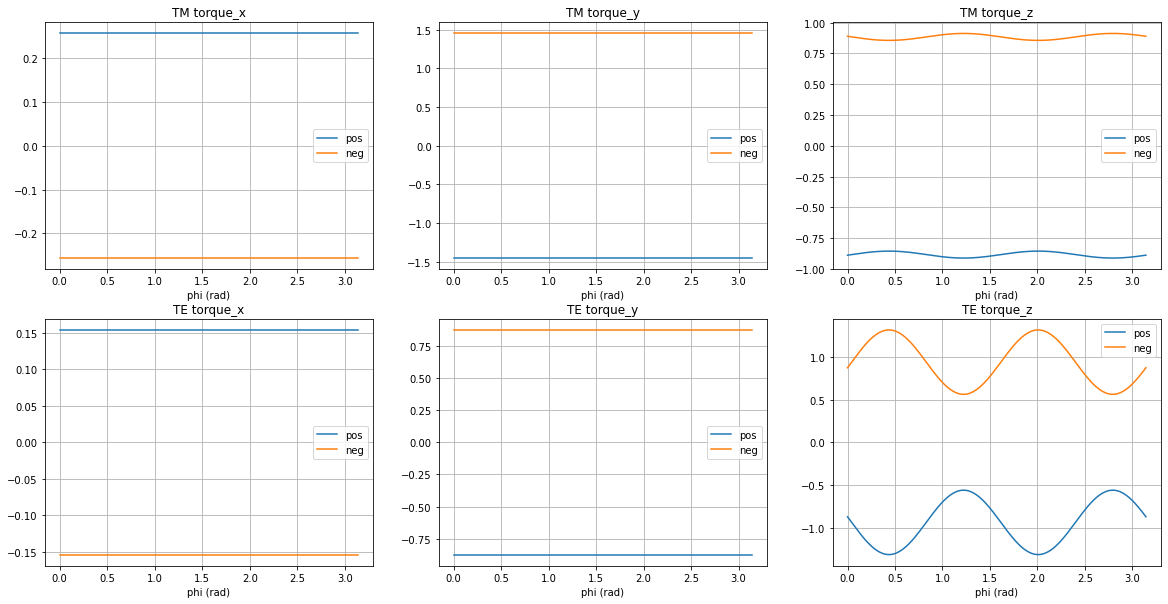

In [23]:
#check what happens if we shitch magnetic field from +H to -H

torque_pos_TM = np.zeros((3, 200))
torque_neg_TM = np.zeros((3, 200))
torque_pos_TE = np.zeros((3, 200))
torque_neg_TE = np.zeros((3, 200))
Phi = np.linspace(0, np.pi, 200)

lam = 1
beta_TM = sol_mode_eq(lam, mode='TM')
beta_TE = sol_mode_eq(lam, mode='TE')
Z  = np.arange(0, width, width/100)
psi = 10*np.pi/180

for i, phi in enumerate(Phi):
     M_pos = get_M_from_H(1, 0, phi, np.pi*10/180)
     M_neg = get_M_from_H(-1, 0, phi, np.pi*10/180)

     E_TM = get_E_field_TM(beta_TM, lam, Z)
     max_E = np.max(np.sqrt(np.abs(np.imag(E_TM[0])**2 + np.real(E_TM[1])**2)))
     E_TM = (E_TM[0]/max_E, E_TM[1]/max_E)
     H_TM_pos = np.mean(ICME_TM(E_TM, phi, M_pos), axis=1)
     torque_pos_TM[:, i] = np.cross(np.array([np.cos(psi), np.sin(psi), 0]), H_TM_pos)

     E_TM = get_E_field_TM(beta_TM, lam, Z)
     max_E = np.max(np.sqrt(np.abs(np.imag(E_TM[0])**2 + np.real(E_TM[1])**2)))
     E_TM = (E_TM[0]/max_E, E_TM[1]/max_E)
     H_TM_neg = np.mean(ICME_TM(E_TM, phi, M_neg), axis=1)
     torque_neg_TM[:, i] = np.cross(np.array([np.cos(psi), np.sin(psi), 0]), H_TM_neg)

     E_TE = get_E_field_TE(beta_TE, lam, Z)
     E_TE = E_TE/np.max(np.abs(E_TE))
     H_TE_pos = np.mean(ICME_TE(E_TE, phi, M_pos), axis=1)
     torque_pos_TE[:, i] = np.cross(np.array([np.cos(psi), np.sin(psi), 0]), H_TE_pos)

     E_TE = get_E_field_TE(beta_TE, lam, Z)
     E_TE = E_TE/np.max(np.abs(E_TE))
     H_TE_neg = np.mean(ICME_TE(E_TE, phi, M_neg), axis=1)
     torque_neg_TE[:, i] = np.cross(np.array([np.cos(psi), np.sin(psi), 0]), H_TE_neg)

fig, ax = plt.subplots(2, 3, figsize=(20, 10))
titles = ['x', 'y', 'z']

for i in range(3):
    ax[0][i].set_title(f"TM torque_{titles[i]}")
    ax[0][i].plot(Phi, torque_pos_TM[i,:], label='pos')
    ax[0][i].plot(Phi, torque_neg_TM[i,:], label='neg')
    ax[0][i].set_xlabel('phi (rad)')
    ax[0][i].legend()
    ax[0][i].grid()

    ax[1][i].set_title(f"TE torque_{titles[i]}")
    ax[1][i].plot(Phi, torque_pos_TE[i,:], label='pos')
    ax[1][i].plot(Phi, torque_neg_TE[i,:], label='neg')
    ax[1][i].set_xlabel('phi (rad)')
    ax[1][i].legend()
    ax[1][i].grid()


<ipython-input-46-607a1566cae3>:41: RuntimeWarning: invalid value encountered in true_divide
  cf1 = ax[1][i].contourf(PHI, PSI, torque_mode[:,:,i]/torque_mode[:,:,i].max(), 100, cmap=cmap)
c:\Python39\lib\site-packages\matplotlib\contour.py:1494: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
c:\Python39\lib\site-packages\matplotlib\contour.py:1495: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
<ipython-input-46-607a1566cae3>:45: RuntimeWarning: invalid value encountered in true_divide
  cf1 = ax[2][i].contourf(PHI, PSI, torque_light[:,:,i]/torque_light[:,:,i].max() - torque_mode[:,:,i]/torque_mode[:,:,i].max(), 100, cmap=cmap)


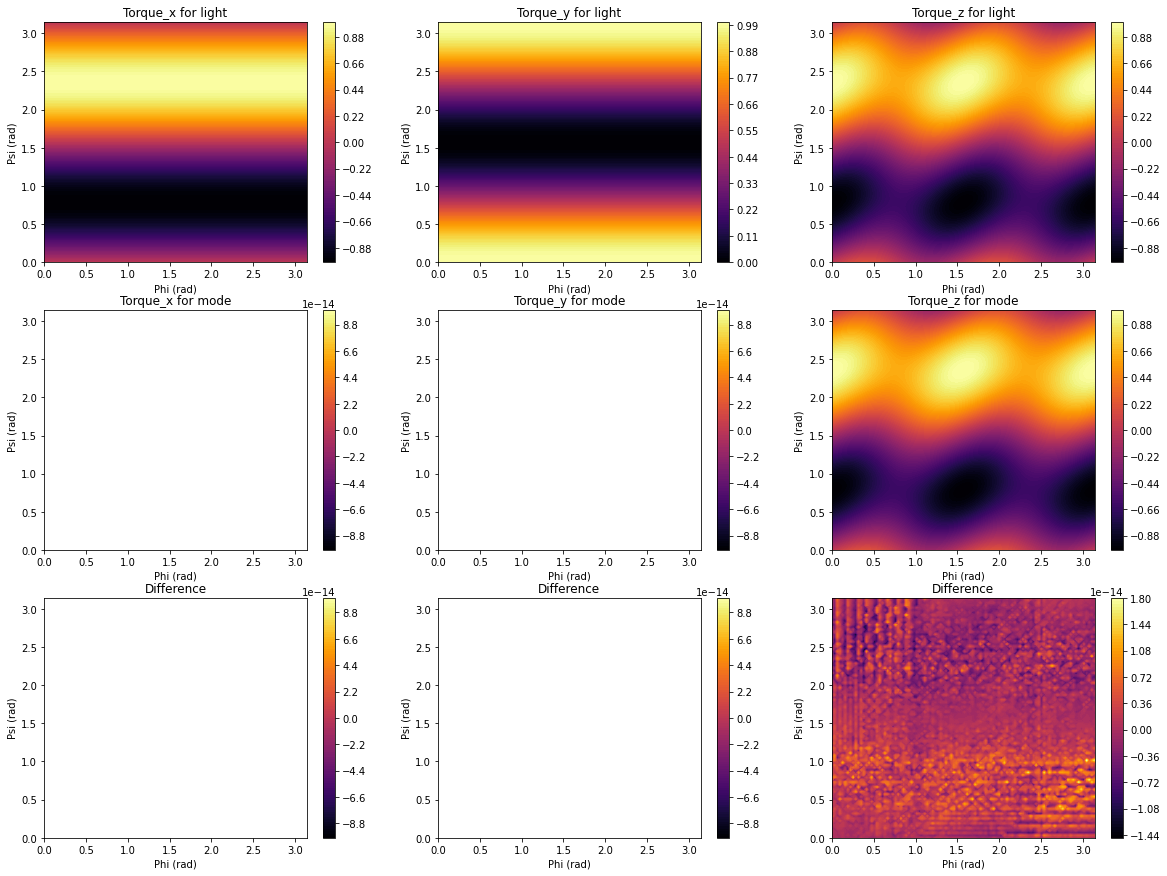

In [46]:
#compare torque from mode field and from light field for TM mode

xsize = 100
ysize = 100
torque_light = np.zeros((xsize, ysize, 3))
torque_mode = np.zeros((xsize, ysize, 3))
PHI = np.linspace(0, np.pi, xsize)
PSI = np.linspace(0, np.pi, ysize)

lam = 1
beta_TM = sol_mode_eq(lam, mode='TM')
Z  = np.arange(0, width, width/100)
angle_of_incidence = 17*np.pi/180

for i, psi in enumerate(PSI):
    for j, phi in enumerate(PHI):
        M = get_M_from_H(1, psi, phi, np.pi*0/180)

        E_TM = get_E_field_TM(beta_TM, lam, Z)
        max_E = np.max(np.sqrt(np.abs(np.imag(E_TM[0])**2 + np.real(E_TM[1])**2)))
        E_TM = (E_TM[0]/max_E, E_TM[1]/max_E)
        H_TM = np.mean(ICME_TM(E_TM, phi, M), axis=1)
        torque_mode[i, j, :] = np.cross(np.array([np.cos(psi), np.sin(psi), 0]), H_TM)

        E_light = (np.cos(angle_of_incidence), 0, -np.sin(angle_of_incidence))
        H_light = ICME_arbirtary_E(E_light, phi, M)
        torque_light[i, j, :] = np.cross(np.array([np.cos(psi), np.sin(psi), 0]), H_light)

fig, ax = plt.subplots(3, 3, figsize=(20, 15))
cmap = plt.get_cmap(name='inferno')
PSI = np.linspace(0, np.pi, xsize)
PHI = np.linspace(0, np.pi, ysize)
PHI, PSI = np.meshgrid(PHI, PSI)

for i in range(3):
    ax[0][i].set_title(f"Torque_{titles[i]} for light")
    cf0 = ax[0][i].contourf(PHI, PSI, torque_light[:,:,i]/torque_light[:,:,i].max(), 100, cmap=cmap)
    fig.colorbar(cf0, ax=ax[0][i])
    
    ax[1][i].set_title(f"Torque_{titles[i]} for mode")
    cf1 = ax[1][i].contourf(PHI, PSI, torque_mode[:,:,i]/torque_mode[:,:,i].max(), 100, cmap=cmap)
    fig.colorbar(cf1, ax=ax[1][i])

    ax[2][i].set_title(f"Difference")
    cf1 = ax[2][i].contourf(PHI, PSI, torque_light[:,:,i]/torque_light[:,:,i].max() - torque_mode[:,:,i]/torque_mode[:,:,i].max(), 100, cmap=cmap)
    fig.colorbar(cf1, ax=ax[2][i])

for ax__ in ax:
    for ax_ in ax__:
        ax_.set_ylabel('Psi (rad)')
        ax_.set_xlabel('Phi (rad)')


Добавим новый функционал. Прошлый блок был с кодом, который олицетворял решение задачи. Теперь пойдем дальше, у нас есть экспреимент в котором мы не можем менять именно эти углы, эти углы удобны для математического описания. В геометрии установки этип углы так просто не настроить. Начнем с того что в решетке (в которой мы планируем эту моду возбуждать) при фиксированной длине волны не при всяком угле $\phi$(по физическому смыслу это угол между осью 100 вектором распространения моды $\beta$) у нас будет возникать мода. Теперь мы будем дополнительно проверять условие возникновения моды, все новые углы и их смысл отображены на рисунке

![qasd](1x/1.png)

In [ ]:
Пояснение к углам и осям


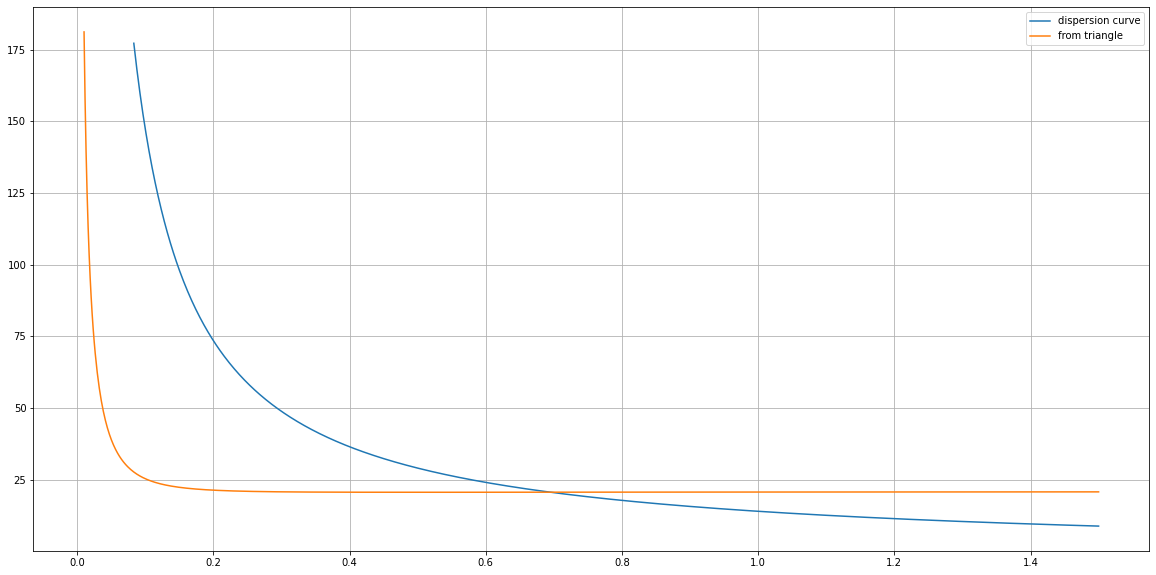

In [26]:
LAM = np.linspace(0.01, 1.5, 1000)
betas = np.array([sol_mode_eq(l, mode='TM') for l in LAM])
plt.figure(figsize=(20, 10))
plt.plot(LAM, betas, label='dispersion curve')

def get_beta_from_triangle(lam, theta, alpha, h, m):
    """
    h - period of structure, m - difraction period 
    """
    ksin = 2*np.pi/lam*np.sin(theta)
    G = 2*np.pi/h*m
    return np.sqrt(ksin**2 + G**2 - 2*ksin*G*np.cos(np.pi/2-alpha))

theta = 17/180*np.pi
alpha = 10/180*np.pi
h = 0.3
m = 1
betas_other = np.array([get_beta_from_triangle(l, theta, alpha, h, m) for l in LAM])
plt.plot(LAM, betas_other, label='from triangle')
plt.grid()
plt.legend()
# betas, betas_other

In [ ]:
#just light in film

PSI = np.linspace(0, np.pi, 100)
PHI = np.linspace(0, np.pi, 100)
TorqueZ_TM = np.zeros((100, 100))
TorqueZ_TE = np.zeros((100, 100))
TorqueX_TM = np.zeros((100, 100))
TorqueX_TE = np.zeros((100, 100))
TorqueY_TM = np.zeros((100, 100))
TorqueY_TE = np.zeros((100, 100))

lam = 1
beta_TM = sol_mode_eq(lam, mode='TM')
beta_TE = sol_mode_eq(lam, mode='TE')
Z  = np.arange(0, width, width/100)

for i, psi in enumerate(PSI):
    for j, phi in enumerate(PHI):
        H_ext = 1
        m1 = H_ext*np.cos(phi-psi)
        m2 = -H_ext*np.sin(phi-psi)
        m3 = 1e-3
        M = (m1, m2, m3)

        E_TM = (1j, 1)

        E_TE = 1

        H_TM_p = ICME_TM(E_TM, phi, M)
        H_TE_p = ICME_TE(E_TE, phi, M)

        TorqueZ_TE[i, j] = np.cross(np.array([np.cos(psi), np.sin(psi), 0]), H_TE_p)[2]
        TorqueZ_TM[i, j] = np.cross(np.array([np.cos(psi), np.sin(psi), 0]), H_TM_p)[2]
        TorqueX_TE[i, j] = np.cross(np.array([np.cos(psi), np.sin(psi), 0]), H_TE_p)[0]
        TorqueX_TM[i, j] = np.cross(np.array([np.cos(psi), np.sin(psi), 0]), H_TM_p)[0]
        TorqueY_TE[i, j] = np.cross(np.array([np.cos(psi), np.sin(psi), 0]), H_TE_p)[1]
        TorqueY_TM[i, j] = np.cross(np.array([np.cos(psi), np.sin(psi), 0]), H_TM_p)[1]

fig, ax = plt.subplots(3, 2, figsize=(30, 30))
cmap = plt.get_cmap(name='inferno')
cmap2 = plt.get_cmap(name='Pastel1')
PHI, PSI = np.meshgrid(PHI, PSI)

#TE
ax[0][0].set_title('Torque_z for TE')
ax[1][0].set_title('Torque_y for TE')
ax[2][0].set_title('Torque_x for TE')
cf0 = ax[0][0].contourf(PHI, PSI, TorqueZ_TE, 200, cmap=cmap)
ax[0][0].contourf(PHI, PSI, TorqueZ_TE, 14, cmap=cmap2, alpha=0.1)
fig.colorbar(cf0, ax=ax[0][0])
cf01 = ax[1][0].contourf(PHI, PSI, TorqueY_TE, 200, cmap=cmap)
ax[1][0].contourf(PHI, PSI, TorqueY_TE, 14, cmap=cmap2, alpha=0.1)
fig.colorbar(cf01, ax=ax[1][0])
cf02 = ax[2][0].contourf(PHI, PSI, TorqueX_TE, 200, cmap=cmap)
ax[2][0].contourf(PHI, PSI, TorqueX_TE, 14, cmap=cmap2, alpha=0.1)
fig.colorbar(cf02, ax=ax[2][0])

#TM
ax[0][1].set_title('Torque_z for TM')
ax[1][1].set_title('Torque_y for TM')
ax[2][1].set_title('Torque_x for TM')
cf1 = ax[0][1].contourf(PHI, PSI, TorqueZ_TM, 200, cmap=cmap)
ax[0][1].contourf(PHI, PSI, TorqueZ_TM, 14, cmap=cmap2, alpha=0.1)
fig.colorbar(cf1, ax=ax[0][1])
cf11 = ax[1][1].contourf(PHI, PSI, TorqueY_TM, 200, cmap=cmap)
ax[1][1].contourf(PHI, PSI, TorqueY_TM, 14, cmap=cmap2, alpha=0.1)
fig.colorbar(cf11, ax=ax[1][1])
cf12 = ax[2][1].contourf(PHI, PSI, TorqueX_TM, 200, cmap=cmap)
ax[2][1].contourf(PHI, PSI, TorqueX_TM, 14, cmap=cmap2, alpha=0.1)
fig.colorbar(cf12, ax=ax[2][1])

for ax__ in ax:
    for ax_ in ax__:
        ax_.set_ylabel('Psi (rad)')
        ax_.set_xlabel('Phi (rad)')

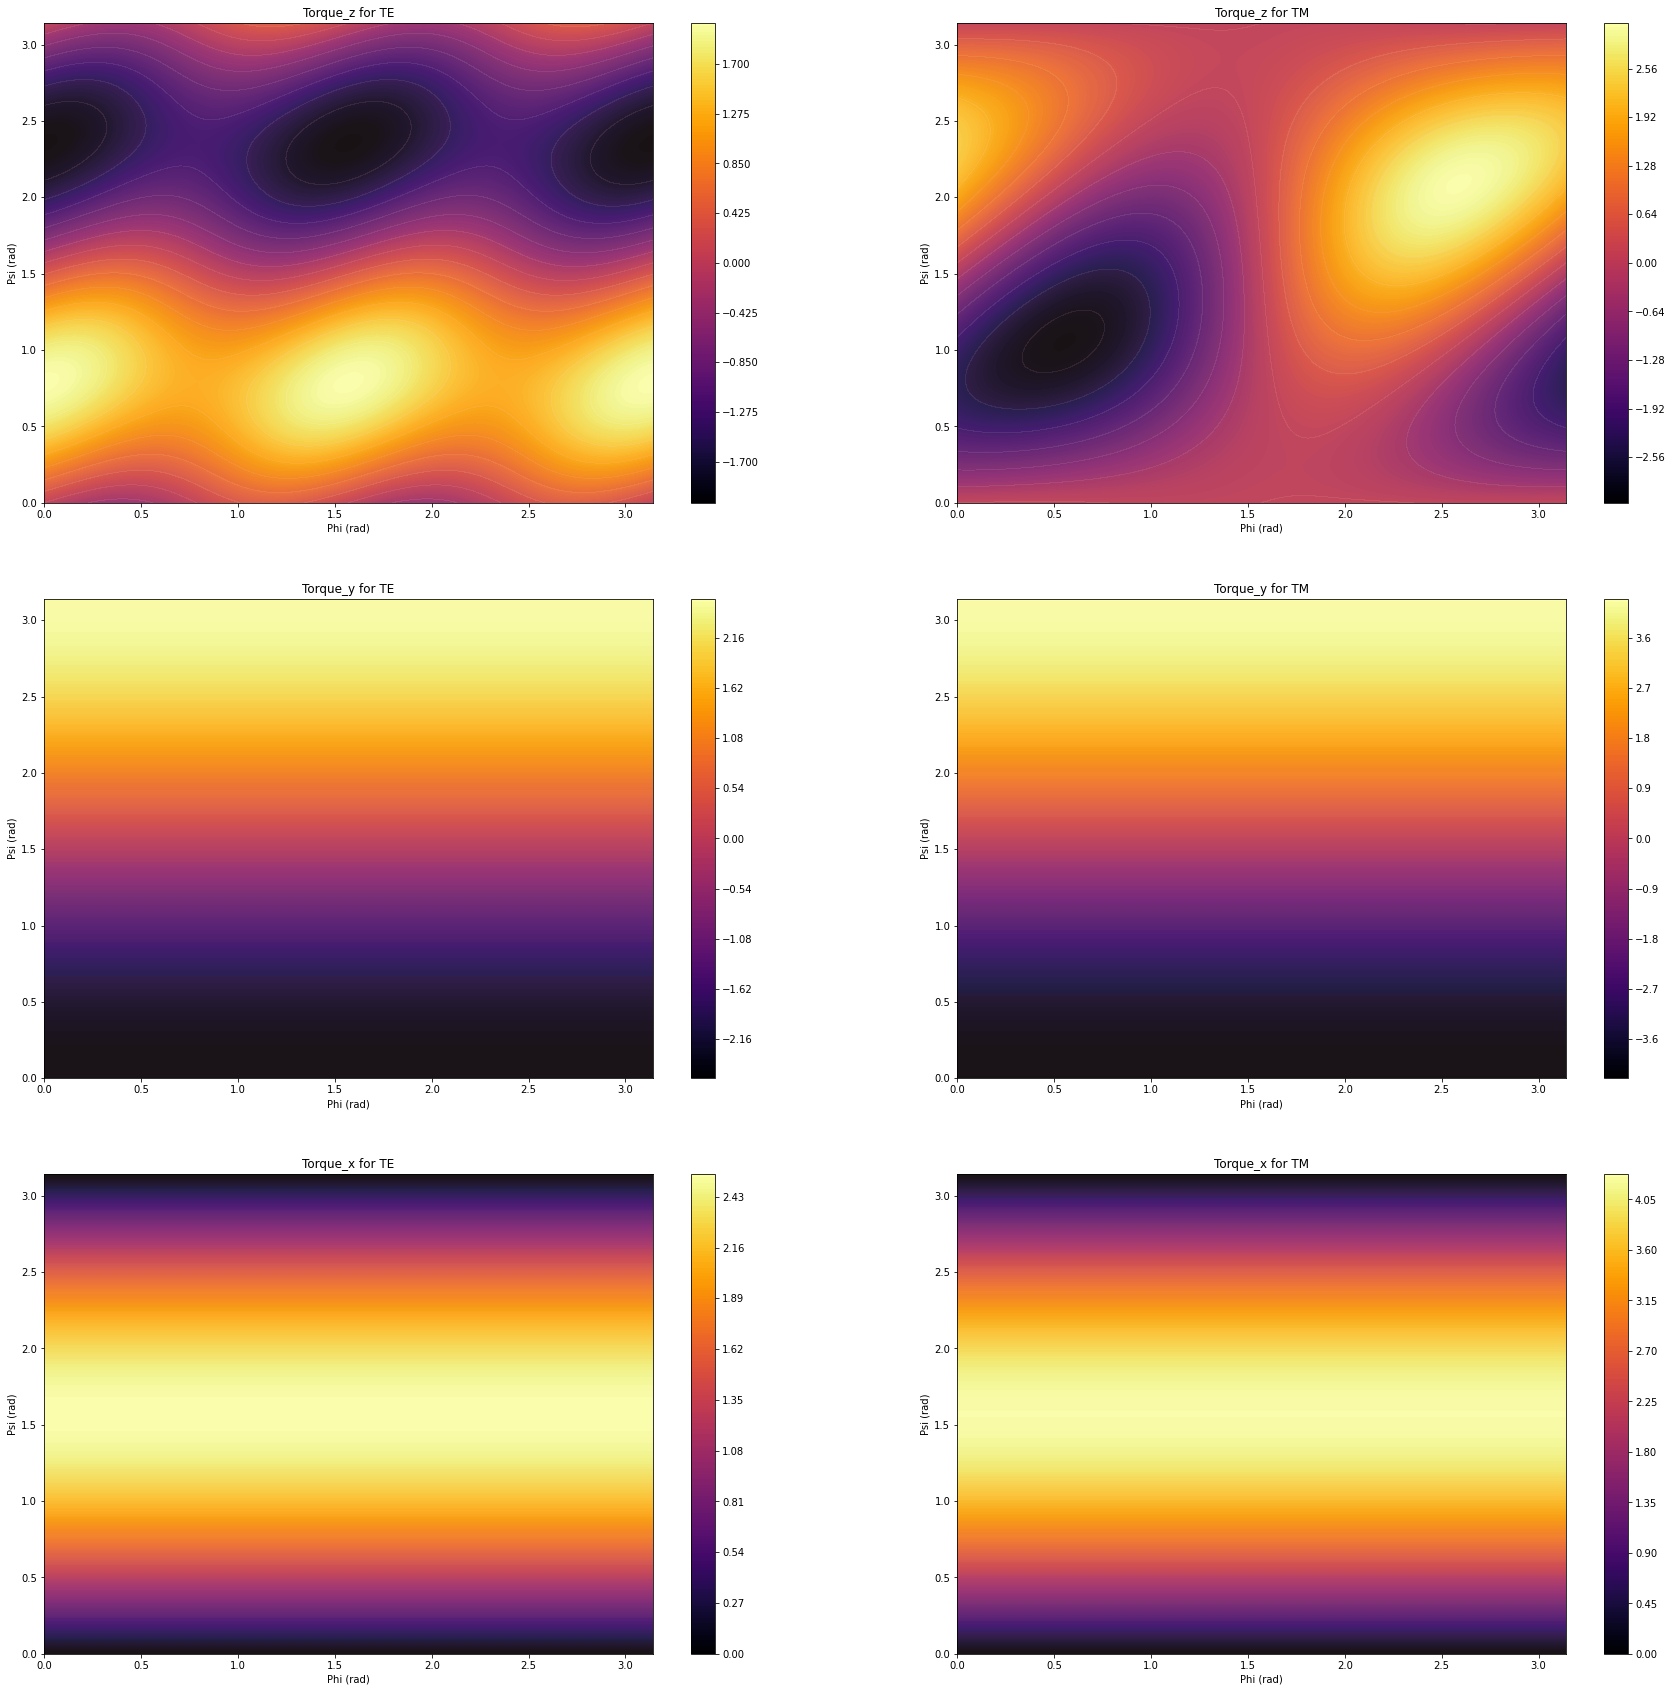

In [3]:
#mode

PSI = np.linspace(0, np.pi, 100)
PHI = np.linspace(0, np.pi, 100)
TorqueZ_TM = np.zeros((100, 100))
TorqueZ_TE = np.zeros((100, 100))
TorqueX_TM = np.zeros((100, 100))
TorqueX_TE = np.zeros((100, 100))
TorqueY_TM = np.zeros((100, 100))
TorqueY_TE = np.zeros((100, 100))

lam = 1
beta_TM = sol_mode_eq(lam, mode='TM')
beta_TE = sol_mode_eq(lam, mode='TE')
Z  = np.arange(0, width, width/100)

for i, psi in enumerate(PSI):
    for j, phi in enumerate(PHI):
        H_ext = 1
        m1 = H_ext*np.cos(phi-psi)
        m2 = -H_ext*np.sin(phi-psi)
        m3 = 0.5
        M = (m1, m2, m3)

        E_TM = get_E_field_TM(beta_TM, lam, Z)
        max_E = np.max(np.sqrt(np.abs(np.imag(E_TM[0])**2 + np.real(E_TM[1])**2)))
        E_TM = (E_TM[0]/max_E, E_TM[1]/max_E)

        E_TE = get_E_field_TE(beta_TE, lam, Z)
        E_TE = E_TE/np.max(np.abs(E_TE))

        H_TM_p = np.mean(ICME_TM(E_TM, phi, M), axis=1)
        H_TE_p = np.mean(ICME_TE(E_TE, phi, M), axis=1)

        TorqueZ_TE[i, j] = np.cross(np.array([np.cos(psi), np.sin(psi), 0]), H_TE_p)[2]
        TorqueZ_TM[i, j] = np.cross(np.array([np.cos(psi), np.sin(psi), 0]), H_TM_p)[2]
        TorqueX_TE[i, j] = np.cross(np.array([np.cos(psi), np.sin(psi), 0]), H_TE_p)[0]
        TorqueX_TM[i, j] = np.cross(np.array([np.cos(psi), np.sin(psi), 0]), H_TM_p)[0]
        TorqueY_TE[i, j] = np.cross(np.array([np.cos(psi), np.sin(psi), 0]), H_TE_p)[1]
        TorqueY_TM[i, j] = np.cross(np.array([np.cos(psi), np.sin(psi), 0]), H_TM_p)[1]

fig, ax = plt.subplots(3, 2, figsize=(30, 30))
cmap = plt.get_cmap(name='inferno')
cmap2 = plt.get_cmap(name='Pastel1')
PHI, PSI = np.meshgrid(PHI, PSI)

#TE
ax[0][0].set_title('Torque_z for TE')
ax[1][0].set_title('Torque_y for TE')
ax[2][0].set_title('Torque_x for TE')
cf0 = ax[0][0].contourf(PHI, PSI, TorqueZ_TE, 200, cmap=cmap)
ax[0][0].contourf(PHI, PSI, TorqueZ_TE, 14, cmap=cmap2, alpha=0.1)
fig.colorbar(cf0, ax=ax[0][0])
cf01 = ax[1][0].contourf(PHI, PSI, TorqueY_TE, 200, cmap=cmap)
ax[1][0].contourf(PHI, PSI, TorqueY_TE, 14, cmap=cmap2, alpha=0.1)
fig.colorbar(cf01, ax=ax[1][0])
cf02 = ax[2][0].contourf(PHI, PSI, TorqueX_TE, 200, cmap=cmap)
ax[2][0].contourf(PHI, PSI, TorqueX_TE, 14, cmap=cmap2, alpha=0.1)
fig.colorbar(cf02, ax=ax[2][0])

#TM
ax[0][1].set_title('Torque_z for TM')
ax[1][1].set_title('Torque_y for TM')
ax[2][1].set_title('Torque_x for TM')
cf1 = ax[0][1].contourf(PHI, PSI, TorqueZ_TM, 200, cmap=cmap)
ax[0][1].contourf(PHI, PSI, TorqueZ_TM, 14, cmap=cmap2, alpha=0.1)
fig.colorbar(cf1, ax=ax[0][1])
cf11 = ax[1][1].contourf(PHI, PSI, TorqueY_TM, 200, cmap=cmap)
ax[1][1].contourf(PHI, PSI, TorqueY_TM, 14, cmap=cmap2, alpha=0.1)
fig.colorbar(cf11, ax=ax[1][1])
cf12 = ax[2][1].contourf(PHI, PSI, TorqueX_TM, 200, cmap=cmap)
ax[2][1].contourf(PHI, PSI, TorqueX_TM, 14, cmap=cmap2, alpha=0.1)
fig.colorbar(cf12, ax=ax[2][1])

for ax__ in ax:
    for ax_ in ax__:
        ax_.set_ylabel('Psi (rad)')
        ax_.set_xlabel('Phi (rad)')

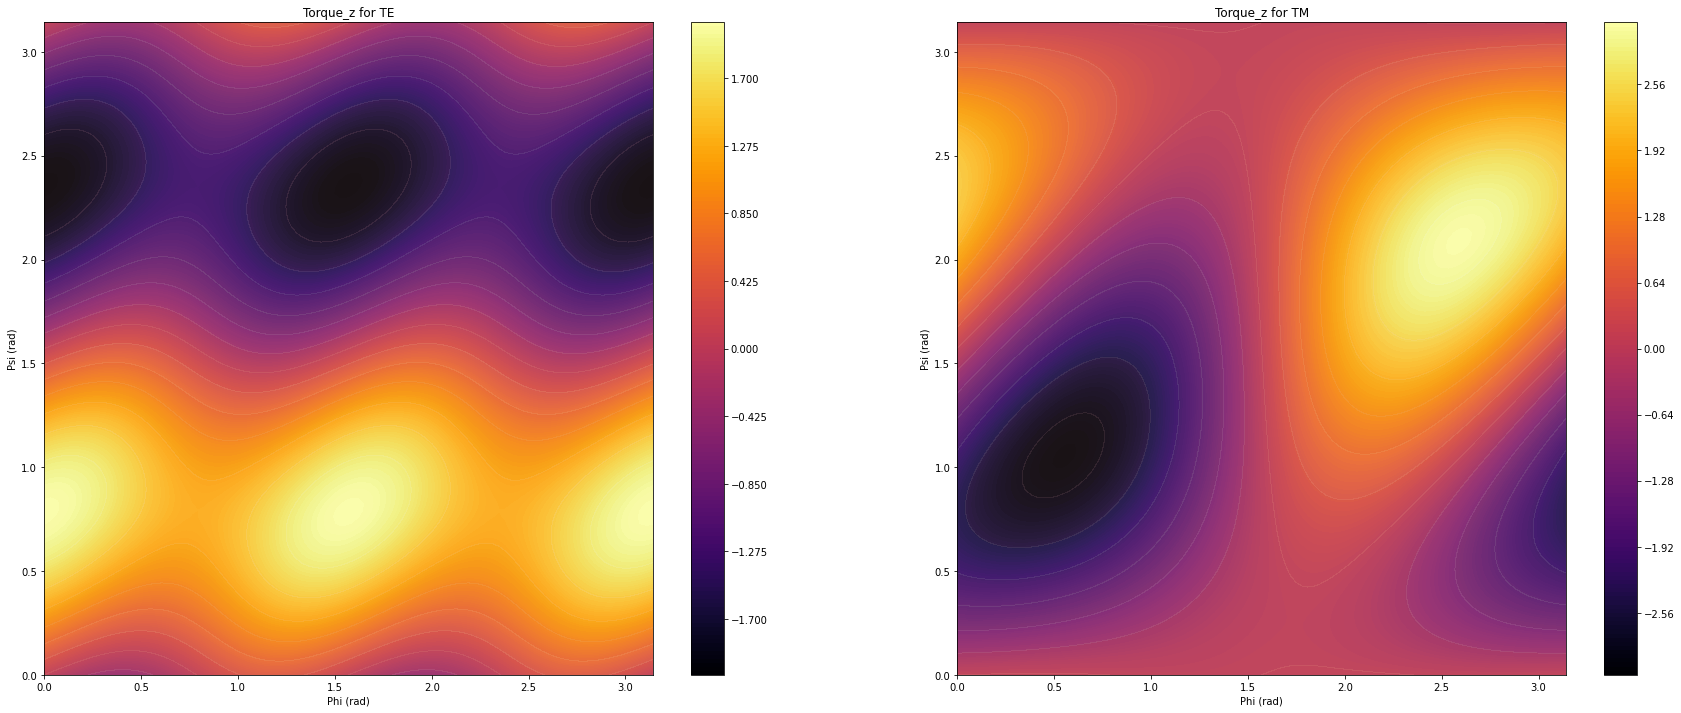

In [17]:
PSI = np.linspace(0, np.pi, 100)
PHI = np.linspace(0, np.pi, 100)
TorqueZ_TM = np.zeros((100, 100))
TorqueZ_TE = np.zeros((100, 100))

lam = 1
beta_TM = sol_mode_eq(lam, mode='TM')
beta_TE = sol_mode_eq(lam, mode='TE')
Z  = np.arange(0, width, width/100)

for i, psi in enumerate(PSI):
    for j, phi in enumerate(PHI):
        H_ext = 1
        m1 = H_ext*np.cos(phi-psi)
        m2 = -H_ext*np.sin(phi-psi)
        m3 = 0.5
        M = (m1, m2, m3)
        
        E_TM = get_E_field_TM(beta_TM, lam, Z)
        max_E = np.max(np.sqrt(np.abs(np.imag(E_TM[0])**2 + np.real(E_TM[1])**2)))
        E_TM = (E_TM[0]/max_E, E_TM[1]/max_E)

        E_TE = get_E_field_TE(beta_TE, lam, Z)
        E_TE = E_TE/np.max(np.abs(E_TE))

        H_TM_p = np.mean(ICME_TM(E_TM, phi, M), axis=1)
        H_TE_p = np.mean(ICME_TE(E_TE, phi, M), axis=1)

        TorqueZ_TE[i, j] = np.cross(np.array([np.cos(psi), np.sin(psi), 0]), H_TE_p)[2]
        TorqueZ_TM[i, j] = np.cross(np.array([np.cos(psi), np.sin(psi), 0]), H_TM_p)[2]

fig, ax = plt.subplots(1, 2, figsize=(30, 12))
cmap = plt.get_cmap(name='inferno')
cmap2 = plt.get_cmap(name='Pastel1')
PHI, PSI = np.meshgrid(PHI, PSI)

#TE
ax[0].set_title('Torque_z for TE')
cf0 = ax[0].contourf(PHI, PSI, TorqueZ_TE, 200, cmap=cmap)
ax[0].contourf(PHI, PSI, TorqueZ_TE, 14, cmap=cmap2, alpha=0.1)
fig.colorbar(cf0, ax=ax[0])

#TM
ax[1].set_title('Torque_z for TM')
cf1 = ax[1].contourf(PHI, PSI, TorqueZ_TM, 200, cmap=cmap)
ax[1].contourf(PHI, PSI, TorqueZ_TM, 14, cmap=cmap2, alpha=0.1)
fig.colorbar(cf1, ax=ax[1])

for ax_ in ax:
    ax_.set_ylabel('Psi (rad)')
    ax_.set_xlabel('Phi (rad)')

In [ ]:
THETA = np.linspace(0, np.pi, 100)
PHI = np.linspace(0, np.pi, 100)

TorqueZ_TE = np.zeros((100, 100))
TorqueZ_TM = np.zeros((100, 100))

Z  = np.arange(0, width, width/100)

for i, theta in enumerate(THETA):
    for j, phi_ in enumerate(PHI):
        phi = phi_
        psi = - theta + phi_

        H_ext = 1
        m1 = H_ext*np.cos(phi-psi)
        m2 = -H_ext*np.sin(phi-psi)
        m3 = 0
        M = (m1, m2, m3)

        beta_TM = sol_mode_eq(lam, mode='TM')
        
        E_TM = get_E_field_TM(beta_TM, lam, Z)
        max_E = np.max(np.sqrt(np.abs(np.imag(E_TM[0])**2 + np.real(E_TM[1])**2)))
        E_TM = (E_TM[0]/max_E, E_TM[1]/max_E)

        H_TM_p = np.mean(ICME_TM(E_TM, phi, M), axis=1)

        TorqueZ_TM[i, j] = np.cross(np.array([np.cos(psi), np.sin(psi), 0]), H_TM_p)[2]

for i, theta in enumerate(THETA):
    for j, phi_ in enumerate(PHI):
        phi = - phi_ + np.pi/2
        psi = (np.pi/2 - theta - phi_)

        H_ext = 1
        m1 = H_ext*np.cos(phi-psi)
        m2 = -H_ext*np.sin(phi-psi)
        m3 = 0
        M = (m1, m2, m3)

        beta_TE = sol_mode_eq(lam, mode='TE')

        E_TE = get_E_field_TE(beta_TE, lam, Z)
        E_TE = E_TE/np.max(np.abs(E_TE))

        H_TE_p = np.mean(ICME_TE(E_TE, phi, M), axis=1)
        
        TorqueZ_TE[i, j] = np.cross(np.array([np.cos(psi), np.sin(psi), 0]), H_TE_p)[2]


fig, ax = plt.subplots(1, 2, figsize=(30, 12))
cmap = plt.get_cmap(name='inferno')
cmap2 = plt.get_cmap(name='Pastel1')
PHI, THETA = np.meshgrid(PHI, THETA)

#TE
ax[0].set_title('|Torque_z| for TE')
cf0 = ax[0].contourf(PHI, THETA, TorqueZ_TE, 200, cmap=cmap)
# ax[0].contourf(PSI, PHI, TorqueZ_TE, 14, cmap=cmap2, alpha=0.1)
fig.colorbar(cf0, ax=ax[0])

#TM
ax[1].set_title('Torque_z for TM')
cf1 = ax[1].contourf(PHI, THETA, TorqueZ_TM, 200, cmap=cmap)
# ax[1].contourf(PHI, PSI_PHI, TorqueZ_TM, 10, cmap=cmap2, alpha=0.4)
# ax[1].contourf(PSI, PHI, TorqueZ_TM, 14, cmap=cmap2, alpha=0.1)
fig.colorbar(cf1, ax=ax[1])

for ax_ in ax:
    ax_.set_xlabel('Phi (rad)')
    ax_.set_ylabel('Theta (rad)')
        

In [ ]:
THETA = np.linspace(0, np.pi, 100)
PHI = np.linspace(0, np.pi, 100)

TorqueZ_TE1 = np.zeros((100, 100))
TorqueZ_TM1 = np.zeros((100, 100))

full_torque = [[]]

Z  = np.arange(0, width, width/100)

for i, theta in enumerate(THETA):
    for j, phi_ in enumerate(PHI):
        psi = phi_
        phi = - theta + phi_

        H_ext = 1
        m1 = H_ext*np.cos(phi-psi)
        m2 = -H_ext*np.sin(phi-psi)
        m3 = 0
        M = (m1, m2, m3)
        
        E_TM = (1j, 0)

        H_TM_p = ICME_TM(E_TM, phi, M)

        TorqueZ_TM1[i, j] = np.cross(np.array([np.cos(psi), np.sin(psi), 0]), H_TM_p)[2]


for i, theta in enumerate(THETA):
    for j, phi_ in enumerate(PHI):
        psi = phi_ - np.pi/2
        phi = - theta + phi_

        H_ext = 1
        m1 = H_ext*np.cos(phi-psi)
        m2 = -H_ext*np.sin(phi-psi)
        m3 = 0
        M = (m1, m2, m3)

        E_TE = 1

        H_TE_p = ICME_TE(E_TE, phi, M)
        
        TorqueZ_TE1[i, j] = np.cross(np.array([np.cos(psi), np.sin(psi), 0]), H_TE_p)[2]


fig, ax = plt.subplots(1, 2, figsize=(30, 12))
cmap = plt.get_cmap(name='inferno')
cmap2 = plt.get_cmap(name='Pastel1')
PHI, THETA = np.meshgrid(PHI, THETA)

#TE
ax[0].set_title('Torque_z for TE')
cf0 = ax[0].contourf(PHI, THETA, TorqueZ_TE1, 200, cmap=cmap)
# ax[0].contourf(PSI, PHI, TorqueZ_TE, 14, cmap=cmap2, alpha=0.1)
fig.colorbar(cf0, ax=ax[0])

#TM
ax[1].set_title('Torque_z for TM')
cf1 = ax[1].contourf(PHI, THETA, TorqueZ_TM1, 200, cmap=cmap)
# ax[1].contourf(PHI, PSI_PHI, TorqueZ_TM, 10, cmap=cmap2, alpha=0.4)
# ax[1].contourf(PSI, PHI, TorqueZ_TM, 14, cmap=cmap2, alpha=0.1)
fig.colorbar(cf1, ax=ax[1])

for ax_ in ax:
    ax_.set_xlabel('Phi (rad)')
    ax_.set_ylabel('Theta (rad)')
        

In [ ]:
section = int(99*1/4)

plt.plot(PHI[0,:], TorqueZ_TM[section,:], label='TE')
plt.plot(PHI[0,:], TorqueZ_TE[section,:], label='TM')
plt.legend()

In [ ]:
t1 = TorqueZ_TM
t2 = TorqueZ_TM1
t1 = (t1 - t1.mean())/t1.max()
t2 = (t2 - t2.mean())/t2.max()
tdiff = t1 - t2


In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(39, 10))
cmap = plt.get_cmap(name='inferno')

ax[0].set_title('Mode')
cf0 = ax[0].contourf(PHI, THETA, t1, 100, cmap=cmap)
fig.colorbar(cf0, ax=ax[0])

ax[1].set_title('Light')
cf1 = ax[1].contourf(PHI, THETA, t2, 100, cmap=cmap)
fig.colorbar(cf1, ax=ax[1])

ax[2].set_title('Diff')
cf2 = ax[2].contourf(PHI, THETA, tdiff, 100, cmap=cmap)
fig.colorbar(cf2, ax=ax[2])

for ax_ in ax:
    ax_.set_xlabel('Phi (rad)')
    ax_.set_ylabel('Theta (rad)')

In [ ]:
#china compare
fig, ax = plt.subplots(figsize = (16, 10))
for i in [1, 30, 45, 60]:
    PHI = np.linspace(-1/2*np.pi, np.pi/2, 200)
    t_TE = []
    shift = i/180*np.pi

    for phi in PHI:
        psi = phi - shift

        H_ext = 1
        m1 = H_ext*np.cos(phi-psi)
        m2 = -H_ext*np.sin(phi-psi)
        m3 = 1e-3       # be carefull with phi close to 0 and 90
        M = (m1, m2, m3)

        E_TE = 1
        H_TE_p = ICME_TE(E_TE, phi, M)
        t_TE.append(np.cross(np.array([np.cos(psi), np.sin(psi), 0]), H_TE_p)[2])

    
    ax.plot(np.linspace(0, np.pi, 200), np.abs(t_TE), label=f"Theta is {i} deg")
ax.grid()
ax.set_ylabel("Torque_z", size=20)
ax.set_xlabel("Phi (rad)", size=20)
ax.legend(fontsize=16)

    